# CNN Model (Notebook version)
CNN Captcha Recognition Model 

## Data Pre-processing

Import the libraries

In [40]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import random
import torch
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [41]:
NUMBER = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
ALPHABET = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
            'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
TABLE = NUMBER+ALPHABET

Load the data, please modify the path by yourself

In [42]:
# Load the data from the Google Drive
# data_dir = Path("/content/drive/MyDrive/Data")

# path of data set for local
data_dir = Path("./dataset")

images = list(data_dir.glob("*.jpg")) #the size of dataset
print("Number of images found: ", len(images))



Number of images found:  10000


Show some samples (Optional)

Shape of image:  (50, 200, 3)
Shape of image:  (50, 200, 3)
Shape of image:  (50, 200, 3)
Shape of image:  (50, 200, 3)


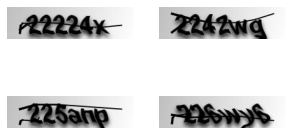

In [43]:
sample_images =images[:4] 
_,ax = plt.subplots(2,2, figsize=(5,3))
for i in range(4):
    img = cv2.imread(str(sample_images[i]))
    print("Shape of image: ", img.shape)
    ax[i//2, i%2].imshow(img)
    ax[i//2, i%2].axis('off')
plt.show()

Customize the data set class

In [44]:
def captcha_to_vector(captcha_str):
    captcha_str = captcha_str.upper()
    vector = np.zeros(36*6, dtype=np.float32)
    for i, char in enumerate(captcha_str):
        ascii = ord(char)
        if 48 <= ascii <= 57:
            index = ascii-48
        elif 65 <= ascii <= 90:
            index = ascii-ord('A')+10
        vector[i*36+index] = 1.0
    return vector

In [45]:
def vector_to_captcha(vector):
    pass

In [46]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images, transform=None, target_transform=None, height=50, width=200):
        self.transform = transform
        self.target_transform = target_transform
        self.images = images
        self.width = width
        self.height = height

    def __getitem__(self, index):
        image = cv2.imread(str(self.images[index]))
        image = cv2.cvtColor(image, cv2.COLOR_RGBA2GRAY)
        image = cv2.resize(image, (self.width, self.height))
        _, image = cv2.threshold(image, 20, 255, cv2.THRESH_BINARY)
        assert len(self.images[index].name.split("_")[0].upper()) == 6
        label = captcha_to_vector(
            self.images[index].name.split("_")[0])

        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.images)

Split the data set

In [47]:
# test data
test_data = images[8000:]  # 2000 for test

# the part for training
training = images[:8000]
valid_data = training[6000:]  # 2000 for validation
train_data = training[:6000]  # 6000 for train

print("test set size:", len(test_data))
print("validation set size:", len(valid_data))
print("train set size:", len(train_data))

train_set = CustomDataset(train_data, transform=transforms.ToTensor())
valid_set = CustomDataset(valid_data, transform=transforms.ToTensor())
test_set = CustomDataset(test_data, transform=transforms.ToTensor())

train_dataloader = DataLoader(dataset=train_set, batch_size=64, shuffle=True)
test_dataloader = DataLoader(dataset=test_set, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(dataset=valid_set, batch_size=64, shuffle=True)


test set size: 2000
validation set size: 2000
train set size: 6000


After Improvement (Origin -> Grayscale -> Binarization)

![](./sample.jpg)

# CNN Model

In [48]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 48, kernel_size=5, padding=2),
            nn.BatchNorm2d(48),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(48, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer5 = nn.Linear(64*3*12, 512)
        self.out = nn.Linear(512, 36*6)

    def forward(self, x):
        # print(x.shape, '#0')  # torch.Size([64, 1, 50, 200]) #0
        x = self.layer1(x)
        # print(x.shape, '#1')  # torch.Size([64, 32, 25, 100]) #1
        x = self.layer2(x)
        # print(x.shape, '#2')  # torch.Size([64, 48, 12, 50]) #1
        x = self.layer3(x)
        # print(x.shape, '#3')  # torch.Size([64, 64, 6, 25]) #1
        x = self.layer4(x)
        # print(x.shape, '#4')  # torch.Size([64, 64, 3, 12]) #1
        x = x.view(-1, 64*3*12)
        # print(x.shape, '#5')
        x = self.layer5(x)
        # print(x.shape, '#6')
        output = self.out(x)
        return output


In [49]:
model = CNN().to(device)

In [50]:
def valid(model, valid_dataloader, device):
    num_correct = 0  # the counter for the correct items
    num_total = 0  # the counter for the total items
    mean_acc = 0  # the accuracy of the validation
    model.eval()  # set the evaluation state of the model
    return 0
    # with torch.no_grad():
    #     pass
    # with torch.no_grad():
    #     for images, labels in valid_dataloader:
    #         images = images.to(device)
    #         labels = labels.to(device)
    #         output = model(images)
    #         i, predicted = torch.max(output.data, 1)
    #         num_total += labels.size(0)
    #         num_correct += (predicted == labels).sum().item()
    # mean_acc = num_correct / num_total * 100
    # return mean_acc

In [51]:

def train(model, train_dataloader, valid_dataloader, device):
    model.train()
    criterion = nn.MultiLabelSoftMarginLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(10):
        model.train()
        for i, (images, labels) in enumerate(train_dataloader):
            images = images.to(device)
            labels = labels.to(device)

            predict = model(images)
            optimizer.zero_grad()
            loss = criterion(predict, labels)
            loss.backward()
            optimizer.step()
            # if (i+1) % 500 == 0:
            #     print("epoch: {} loss: {:.4f}".format(epoch, loss.item()))
        print(epoch,loss.item())
        # if (epoch+1) % 5 == 0:
        #     # accuracy = valid(model, valid_dataloader, device)
        #     accuracy=1
        #     print("epoch: {} loss: {:.f} accuracy: {:.4f}".format(
        #         epoch, loss.item(), accuracy))

In [52]:
train(model, train_dataloader, valid_dataloader, device)

0 0.08573459833860397
1 0.04199344664812088
2 0.010930072516202927
3 0.00593776348978281
4 0.003283726517111063
5 0.0013787716161459684
6 0.00037253490881994367
7 0.0001732365635689348
8 0.00011899306991836056
9 0.00010626809671521187
